# Описание проекта

Подготовим прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков. Исходный датасет содержит обучающую и тестовую выборки со всеми признаками. В нашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверим по нашей инструкции их на корректность.


In [1]:
pip install -U scikit-learn --user #установим последнюю версию scikit learn

Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.22.2.post1)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # импортируем необходимы для проекта библиотеки
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

# 1. Подготовка данных

### 1.1. Откройте файлы и изучите их.

In [3]:
full = pd.read_csv('/datasets/gold_recovery_full.csv') # загружаем необходимые датасеты

In [4]:
test = pd.read_csv('/datasets/gold_recovery_test.csv')

In [5]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')

### 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [6]:
def effectivity(col): # функция для расчета эффективности обогащения
    C = col['rougher.output.concentrate_au']
    F=col['rougher.input.feed_au']
    T=col['rougher.output.tail_au']
    try:
        recovery = (C*(F-T))/(F*(C-T))*100
        return recovery
    except:
        return np.nan

In [7]:
train_clean = train.dropna() # удаляем пропуски

In [8]:
effectivity(train_clean).describe() 

count    11017.000000
mean        82.741888
std         13.590523
min         -0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
dtype: float64

In [9]:
train_clean['rougher.output.recovery'].describe()

count    11017.000000
mean        82.741888
std         13.590523
min          0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [10]:
print('MAE =', mean_absolute_error(effectivity(train_clean), train_clean['rougher.output.recovery']))
# расчитаем отклонение ошибки между расчетным и имеющимся значениями эффективности обогащения

MAE = 9.555596961987514e-15


Отклонение ошибки минимальное имеющимся данным эффективности обогащения можно доверять.

### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [11]:
set(train.columns)-set(test.columns) # признаки недоступные в тестовой выборке

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Все эти данные относятся уже к еще не определенным параметрам относящимся к технологическим процессам и немогут находиться в тестовой выборке. В тестовой выборке могут находиться только те параметры которые определены на старте и не изменяються во время технологическиго процесса.

Признаки с итоговыми данными или выходными характеристиками продуктов на каждом технологическом процессе.

### 1.4. Проведите предобработку данных.

In [12]:
imputer = KNNImputer() # генерация функции заполнения пропусков

In [13]:
full.loc[:, full.columns != 'date'] = imputer.fit_transform(full.loc[:, full.columns != 'date'])
# заполнение пропусков в исходном датасете

In [14]:
train.loc[:, train.columns != 'date'] = imputer.fit_transform(train.loc[:, train.columns != 'date'])
# заполнение пропусков в учебном датасете

In [15]:
test.loc[:, test.columns != 'date'] = imputer.fit_transform(test.loc[:, test.columns != 'date'])
# заполнение пропусков в тестовом датасете

Мы знаем , что  соседние по времени параметры часто похожи. Поэтому идеально использовать при заполении пропусков KNNImputer

# 2. Анализ данных

### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

In [16]:
elements = {'au': 'au', #словарь элементов
          'ag': 'ag',
           'pb': 'pb'}

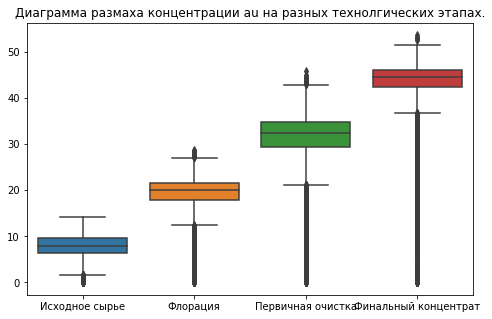

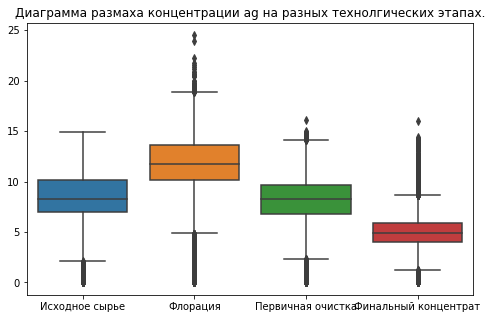

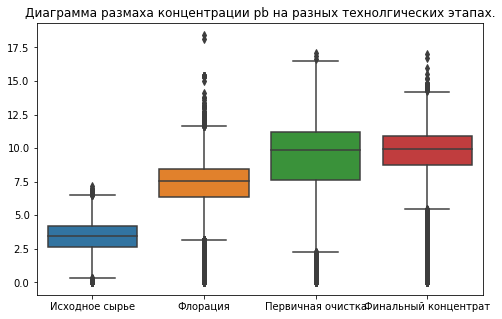

In [17]:
for key in elements.keys(): 
# цикл для формирования диаграмм размаха концентраций элементов Au, Ag, Pb на различных этапах очистки
    plt.figure(figsize=(8,5))
    plt.title('Диаграмма размаха концентрации {} на разных технолгических этапах.'.format(elements[key]))
    sns.boxplot(data=full[['rougher.input.feed_' + elements[key],
                           'rougher.output.concentrate_' + elements[key], 
                           'primary_cleaner.output.concentrate_'+ elements[key], 
                           'final.output.concentrate_' + elements[key],]])
    plt.xticks([0,1,2,3], ['Исходное сырье', 'Флорация', 'Первичная очистка', 'Финальный концентрат'])
plt.show()

Концентрация золота растет, серебра падает, а концентрация свинца незначительно возрасла на флорации и стабильна на первичной очистке и финале.

### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

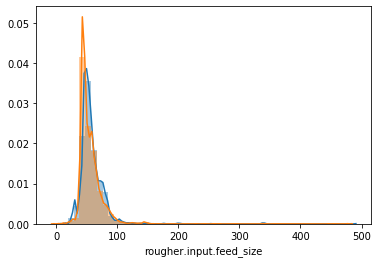

In [18]:
sns.distplot(train['rougher.input.feed_size']) 
# график распределения размеров гранул перед флорацией в тренировочной выборке
sns.distplot(test['rougher.input.feed_size'])
# график распределения размеров гранул перед флорацией в третосовй выборке

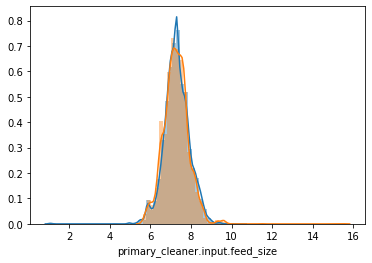

In [19]:
sns.distplot(train['primary_cleaner.input.feed_size'])
# график распределения размеров гранул в финальном концентрате в тренировочной выборке
sns.distplot(test['primary_cleaner.input.feed_size'])
# график распределения размеров гранул в финальном концентрате в тестовой выборке

Распределения размеров гранул сырья перед флорацией и в финальном концентрате в тестовой и тренировочкой выборках практически не отличаются. Оценка моделей будет одыкватной.

### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

In [20]:
def filter_outliers(df, column_name, remove_outliers=False):
# функция фильтрации аномалий
    #print(column_name)
    df_column = df[column_name]
    quartile_1 = df_column.describe()['25%']
    quartile_3 = df_column.describe()['75%']
    interquartile_range = quartile_3 - quartile_1
    upper_whisker = quartile_1 + 1.5 * interquartile_range
    lower_whisker = max(quartile_1 - 1.5 * interquartile_range, df_column.min())
    outliers = df[(df_column < lower_whisker) | (df_column > upper_whisker) |
                 (df_column.isnull())]
    if remove_outliers:
        df.drop(outliers.index, inplace=True)
#num_rows_before = data.shape[0]

#### Тренировочкая выборка. Поиск аномалий и фильтрация.

In [21]:
train['rougher.input.feed_sum'] = train['rougher.input.feed_ag'] + train['rougher.input.feed_pb'] + train['rougher.input.feed_sol'] + train['rougher.input.feed_au']
# суммарные значения входного сырья

In [22]:
train['final.output.concentrate_sum'] = train['final.output.concentrate_ag'] + train['final.output.concentrate_pb'] + train['final.output.concentrate_sol'] + train['final.output.concentrate_au']
# суммарные значения финального концентрата
#train['primary_cleaner.output.concentrate_sum'] = train['primary_cleaner.output.concentrate_ag'] + train['primary_cleaner.output.concentrate_pb'] + train['primary_cleaner.output.concentrate_sol'] + train['primary_cleaner.output.concentrate_au']
train['rougher.output.concentrate_sum'] = train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_pb'] + train['rougher.output.concentrate_sol'] + train['rougher.output.concentrate_au']
# суммарные значения концентрата после флорации

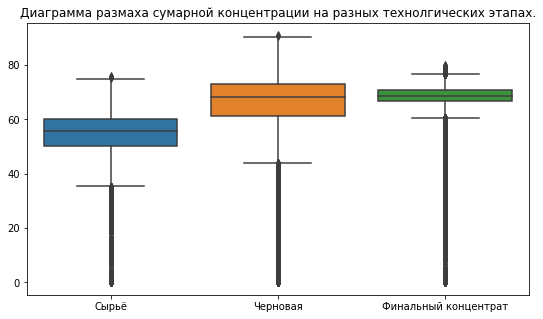

In [23]:
# формирование диаграмм размаха суммарной концентрации на разных тех процессах на тренировочной выборке
plt.figure(figsize=(9,5)) 
plt.title('Диаграмма размаха сумарной концентрации на разных технолгических этапах.')
sns.boxplot(data=train[['rougher.input.feed_sum','rougher.output.concentrate_sum', 'final.output.concentrate_sum']])
plt.xticks([0,1,2], ['Сырьё','Черновая','Финальный концентрат'])
plt.show()

In [24]:
# фильтрация выбросов
columns = ['rougher.input.feed_sum','rougher.output.concentrate_sum','final.output.concentrate_sum']
for column_name in columns:
    filter_outliers(train, column_name, remove_outliers=True)

In [25]:
num_rows_before = train.shape[0]

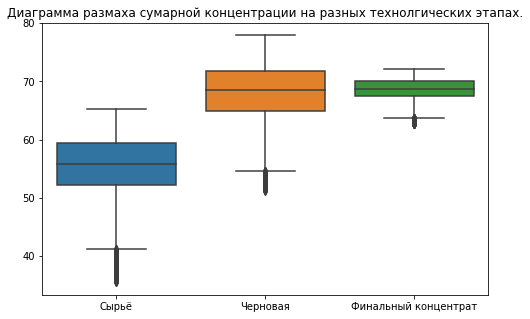

In [26]:
# формирование диаграмм размаха суммарных концентрация по тех процессам
plt.figure(figsize=(8,5))
plt.title('Диаграмма размаха сумарной концентрации на разных технолгических этапах.')
sns.boxplot(data=train[['rougher.input.feed_sum','rougher.output.concentrate_sum', 'final.output.concentrate_sum']])
plt.xticks([0,1,2], ['Сырьё','Черновая','Финальный концентрат'])
plt.show()

In [27]:
train = train.drop(['rougher.input.feed_sum','final.output.concentrate_sum','rougher.output.concentrate_sum'], axis=1)
# сброс значений жля сохранения целосности данных тренировочной выборки

#### Тестовая выборка. Поиск аномалий и фильтрация.

In [28]:
test['rougher.input.feed_sum'] = test['rougher.input.feed_ag'] + test['rougher.input.feed_pb'] + test['rougher.input.feed_sol'] + test['rougher.input.feed_au']
# суммарные значения концентраций исходного сырья

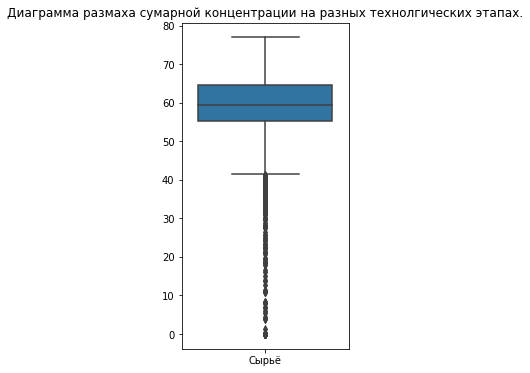

In [29]:
# формироввание диаграммы размаха и поиск выбросов
plt.figure(figsize=(3,6))
plt.title('Диаграмма размаха сумарной концентрации на разных технолгических этапах.')
sns.boxplot(data=test[['rougher.input.feed_sum']])
plt.xticks([0], ['Сырьё'])
plt.show()

In [30]:
filter_outliers(test, 'rougher.input.feed_sum', remove_outliers=True)
# фильтрация выбросов и аномалий

In [31]:
num_rows_before = test.shape[0]

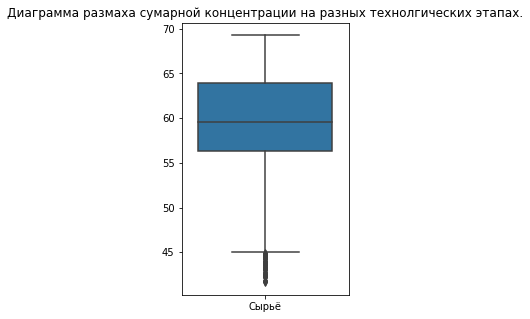

In [32]:
# проверка результата фильтрации
plt.figure(figsize=(3,5))
plt.title('Диаграмма размаха сумарной концентрации на разных технолгических этапах.')
sns.boxplot(data=test[['rougher.input.feed_sum']])
plt.xticks([0], ['Сырьё'])
plt.show()

In [33]:
test = test.drop(['rougher.input.feed_sum'], axis=1)
# сброс значений жля сохранения целосности данных тестовой выборки

Аномальные значения это сбои работы детектирующих систем поэтому удаляем их. Так как это можем привести к некорректному обучению моделей.

# 3. Модель

### 3.1. Напишите функцию для вычисления итоговой sMAPE.

In [34]:
def smape_end(target_rougher, predict_rougher, target_final, predict_final):
    smape_rougher = 100/len(target_rougher) * np.sum(2 * np.abs(predict_rougher - target_rougher) / 
                                                     (np.abs(target_rougher) + np.abs(predict_rougher)))
    smape_final = 100/len(target_final) * np.sum(2 * np.abs(predict_final - target_final) / 
                                                 (np.abs(target_final) + np.abs(predict_final)))
    return 0.25*(smape_rougher) + 0.75*(smape_final)

### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [35]:
train.set_index('date', inplace=True)

In [36]:
full.set_index('date', inplace=True)
test.set_index('date', inplace=True)

In [37]:
test['rougher.output.recovery'] = full['rougher.output.recovery']
test['final.output.recovery'] = full['final.output.recovery']

In [38]:
features_train_1 = train.drop(set(train.columns)-set(test.columns), axis=1).filter(regex='^rougher',axis=1)

In [39]:
features_train_1 = features_train_1.drop(['rougher.output.recovery'], axis=1)

In [40]:
target_train_1 = train['rougher.output.recovery']

In [41]:
features_train_2 = train.drop(set(train.columns)-set(test.columns), axis=1)
features_train_2 = features_train_2.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [42]:
target_train_2 = train['final.output.recovery']

In [43]:
features_test_1 = test.filter(regex='^rougher',axis=1).drop(['rougher.output.recovery'], axis=1)

In [44]:
target_test_1 = test['rougher.output.recovery']

In [45]:
features_test_2 = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [46]:
target_test_2 = test['final.output.recovery']

#### Модель решающего дерева.

In [47]:
for depth in range(1, 5):
    model = tree.DecisionTreeRegressor(random_state=12345, max_depth = depth)
    y_pred_1 = cross_val_predict(model, features_train_1, target_train_1, cv=5)
    y_pred_2 = cross_val_predict(model, features_train_2, target_train_2, cv=5)
    print('depth',depth)
    print('Итоговое sMAPE:',smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))
print()

depth 1
Итоговое sMAPE: 9.066045285443309
depth 2
Итоговое sMAPE: 8.695346042399134
depth 3
Итоговое sMAPE: 8.625707450157218
depth 4
Итоговое sMAPE: 9.17811193028897



#### Модель случайного леса.

In [48]:
for depth in range(5, 8):
    print('depth',depth)
    for num in range(27, 30):
        model_1 = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators = num)
        y_pred_1 = cross_val_predict(model_1, features_train_1, target_train_1, cv=5)
        y_pred_2 = cross_val_predict(model_1, features_train_2, target_train_2, cv=5)
        print('num',num)
        print('Итоговое sMAPE:',smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))
    print()
    
print()

depth 5
num 27
Итоговое sMAPE: 8.407514815007476
num 28
Итоговое sMAPE: 8.390747574224843
num 29
Итоговое sMAPE: 8.377484061185907

depth 6
num 27
Итоговое sMAPE: 8.554062806214766
num 28
Итоговое sMAPE: 8.534348136889694
num 29
Итоговое sMAPE: 8.506265187400784

depth 7
num 27
Итоговое sMAPE: 8.553690085653734
num 28
Итоговое sMAPE: 8.559191621095659
num 29
Итоговое sMAPE: 8.538797159726895




#### Модель линейной регрессии.

In [49]:
model_2 = LinearRegression()
y_pred_1 = cross_val_predict(model_2, features_train_1, target_train_1, cv=5)
y_pred_2 = cross_val_predict(model_2, features_train_2, target_train_2, cv=5)
print('Итоговое sMAPE:',smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))

Итоговое sMAPE: 9.724208225074484


#### Модель градиентного бустинга.

In [50]:
model_3 = GradientBoostingRegressor(max_depth=1, random_state=12345, loss='ls')
y_pred_1 = cross_val_predict(model_3, features_train_1, target_train_1, cv=5)
y_pred_2 = cross_val_predict(model_3, features_train_2, target_train_2, cv=5)
print('Итоговое sMAPE:',smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))

Итоговое sMAPE: 8.004618587061234


#### Проверка на тестовой выборе.

In [51]:
model_test_1 = GradientBoostingRegressor(max_depth=1, random_state=12345, loss='ls')
model_test_2 = GradientBoostingRegressor(max_depth=1, random_state=12345, loss='ls')
model_test_1.fit(features_train_1, target_train_1)
model_test_2.fit(features_train_2, target_train_2)
y_pred_1 = pd.Series(model_test_1.predict(features_test_1))
y_pred_2 = pd.Series(model_test_2.predict(features_test_2))

In [52]:
target_test_1 = target_test_1.reset_index(drop=True)
target_test_2 = target_test_2.reset_index(drop=True)

In [53]:
smape_end(target_test_1, y_pred_1, target_test_2, y_pred_2)

8.852048856931068

#### Приверка модели на адекватность

In [54]:
dummy_regr_1 = DummyRegressor(strategy="mean")
dummy_regr_2 = DummyRegressor(strategy="mean")
dummy_regr_1.fit(features_train_1, target_train_1)
dummy_regr_2.fit(features_train_2, target_train_2)
y_pred_1 = dummy_regr_1.predict(features_test_1)
y_pred_2 = dummy_regr_2.predict(features_test_2)

In [55]:
smape_end(target_test_1, y_pred_1, target_test_2, y_pred_2)

10.049061324835321

Метрика по средниму больше модель адекватная. И эфективнее средних значений.

1. Итоговый sMAPE 8.85% на тестовой выборке и 8.00% на тренировочной выборке. При поиске параметров и выборе моделей. Найдна с минимальным значением sMAPE.
2. Выбранная модель GradientBoostingRegressor(max_depth=1)